# In this notebook, we define a simple Python-based Molecular Dynamics engine which will allow for the use of ML-based Ab-Initio Molecular Dynamics Analogues.

In [191]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import numpy.random as rand
import numpy.linalg as la

## Change this according to your local environment

In [192]:
sys.path.append('/Users/steven/Documents/Research/Projects/MLED/ML-electron-density/util')

First, we define the engine which will power the whole simulation.

The engine object needs to keep track of every atom's individual position, and will propagate the system forward by computing the forces acting on each atom and then propagating forward by a time step.

In [193]:
class MD_engine():
    
    def __init__(self,input_atoms=[],cell=np.eye(3), dx=.1,verbosity=1,model='SHO',store_trajectory=True):
        """
        Initialize the features of the system, which include:
        atoms: Atoms in the unit cell
        cell:  Vectors which define the dimensions of the unit cell
        dx:    Perturbation distance used to evaluate the gradient in potential energy
        model: The energy model used
        time:  Internal timer for simulations
        """
        self.verbosity = verbosity

        self.atoms = []  # List of atoms 
        for atom in input_atoms:
            print(atom)
            self.add_atom(atom)
        
        self.dx = dx
        self.cell = np.array(cell)
        
        self.model = model

        self.time = 0.
        
        self.store_trajectory=store_trajectory
        
        if store_trajectory:
            self.trajs=[]
            for n in range(len(self.atoms)):
                self.trajs.append([])
        
    def add_atom(self,atom):
        """
        Helper function which adds atoms to the simulation
        """
        if self.verbosity==4:
            print("Adding atom",atom)
        self.atoms.append(atom)    
    

    def get_config_energy(self,atoms):
        """
        The positions of the atoms are passed to a given model of choice,
        in which the positions are converted into the configuration which is
        appropriate to be parsed by the model.

        For instance, the positions may need to be converted into 
        atom-centered symmetry functions for the Gaussian Process model. By
        passing in the positions, the necessary mapping is performed, and then
        the appropriate model is called.
        """ 
        
        positions=[atom.position for atom in self.atoms]
        
        if self.model=='SHO':
            return SHO_energy(atoms)
    
        #######
        # Below are 'hooks' where we will later plug in to our machine learning models
        #######
        if self.model=='GP':
            config = GP_config(positions)
            return GP_energy(config)

        if self.model=="KRR":
            config = KRR_config(positions)
            return GP_energy(config)
        
        
        if self.model=='LJ':
            return LJ_energy(atoms)
    
    def update_atom_forces(self):
        """
        Perturbs the atoms by a small amount dx in each direction
        and models the gradient (and thus the force) 
        via a finite-difference approximation.
        """
        
        E0 = self.get_config_energy(self.atoms)
        atoms = self.atoms
        for atom in atoms:
            for coord in range(3):
                atom.position[coord] += self.dx
                Eplus = self.get_config_energy(atoms)
                
                atom.position[coord] -= 2*self.dx
                Eminus = self.get_config_energy(atoms)
                atom.position[coord] += self.dx
            
                atom.force[coord] = -first_derivative_2nd(Eminus,Eplus,self.dx)
                if self.verbosity==5:
                    print("Just set force on atom's coordinate",coord," to be ", -first_derivative_2nd(Eminus,Eplus,self.dx))
            
            atom.apply_constraint()
        
        
    def take_timestep(self,dt,method='Verlet'):
        
        temp_num=0.
        #####
        # Bad first order Euler method
        # Undesirable because accumulates error at order dt**2 which 
        # adds up quickly for long simulations
        #####
        if method=='FO_Euler':
            for atom in atoms:
                for coord in range(3):
                    atom.prev_pos[coord] = np.copy(atom.position[coord])
                    atom.position[coord] += atom.velocity[coord]*dt+ atom.force[coord]*dt**2/atom.mass
                    atom.velocity[coord] += atom.force[coord]*dt/atom.mass
                    
        ######
        # Superior Verlet integration
        # Citation:  https://en.wikipedia.org/wiki/Verlet_integration
        ######
        elif method=='Verlet':
            for atom in atoms:
                for coord in range(3):
                    temp_num = np.copy(atom.position[coord])
                    atom.position[coord] = 2*atom.position[coord] - atom.prev_pos[coord] + atom.force[coord]*dt**2
                    atom.velocity[coord] += atom.force[coord]*dt/atom.mass     
                    atom.prev_pos[coord] = np.copy(temp_num)

        
        
        if self.store_trajectory:
            for n in range(len(self.atoms)):
                self.trajs[n].append(np.copy(self.atoms[n].position))
        self.time+=dt
    
    def run(self,tf,dt):
        """
        Handles timestepping; at each step, calculates the force and then
        advances via the take_timestep method.
        
        """
        if self.time==0:
            self.update_atom_forces()
            self.take_timestep(dt,method='FO_Euler')
        
        while self.time<tf:
            self.update_atom_forces()
            self.take_timestep(dt)
            

            
            if self.verbosity>=3:
                self.print_positions()
            
            
            if self.model=='GP':
            
                valid = self.gauge_uncertainty(self.atoms,self.threshold)
                if valid:                    
                    continue
                else:
                    take_timestep(-dt)
                    self.time -=dt
                    call_dft()
                    train_model()
                

        

    def gauge_uncertainty(self,positions,threshold):
        """
        For later implementation with the Gaussian Process model.
        Will check to see if the uncertainty of the model's prediction of the energy
        within a given configuration is within an acceptable bound given by threshold.
        
        If it is unacceptable, the current configuration is exported into a Quantum ESPRESSO run,
        which is then added into the ML dataset and the model is re-trained.
        """
        config=GP_config(positions)
        sigma=get_config_uncertainty(config)
        if sigma>threshold:
            return False
        else:
            return True
        
    def assert_boundary_conditions(self,atoms):
        """
        We seek to have our atoms be entirely within the unit cell, that is,
        for bravais lattice vectors a1 a2 and a3, we want our atoms to be at positions
        
         x= a a1 + b a2 + c a3
         where a, b, c in [0,1)
         
         So in order to impose this condition, we invert the matrix equation such that
        
          [a11 a12 a13] [a] = [x1]
          [a21 a22 a23] [b] = [x2]
          [a31 a32 a33] [c] = [x3]
          
          And if we find that a, b, c not in [0,1) we modulo by 1.
        """
        a1 = self.cell[0]
        a2 = self.cell[1]
        a3 = self.cell[2]
        print(a1)
        print(a2)
        print(a3)
        for atom in atoms:
            print('Atom positions:',atom.position)
            coords= np.dot(la.inv(self.cell),atom.position)
            print('Resultant coords:',coords)
            
            atom.position= a1 * (coords[0]%1) + a2 * (coords[1]%1) + a3 * (coords[2]%1 )
            print("new position:",atom.position)
            
    def print_positions(self):
        
        print("T=",self.time)
        for n in range(len(self.atoms)):
            pos=self.atoms[n].position
            print('Atom %d:'%n,pos[0],pos[1],pos[2])

## Set up SHO configuration and Energy functions

Note that this SHO energy is a very simple model which only has the atoms oscillating about their initial positions; there is no interactions between the atoms whatsoever. This is merely built as a test of the MD engine to ensure that it is running and propagating the atoms correctly.

In [194]:
def SHO_config(atoms):
    return [atom.position for atom in atoms]

def SHO_energy(atoms,kx=10.0,ky=1.0,kz=1.0):
    
    if type(kx) is list :
        if len(kx)!=len(atoms):
            print("Warning! Number of Kx supplied is not equal to number of atoms")
    elif type(kx) is float:
        kx=[kx]*len(atoms)
    
    if type(ky) is list:
        if len(ky)!=len(atoms):
            print("Warning! Number of Ky supplied is not equal to number of atoms")
    elif type(ky) is float:
        ky=[ky]*len(atoms)
     
    
    if type(kz) is list:
        if len(kz)!=len(atoms):
            print("Warning! Number of Kz supplied is not equal to number of atoms")
    elif type(kz) is float:
        kz=[kz]*len(atoms)
    
    init_pos  = [atom.initial_pos for atom in atoms]
    positions = [atom.position for atom in atoms]
    
    K = [kx,ky,kz]
    
    E=0
    for m in range(len(atoms)):
        for n in range(3):
            E+= K[n][m] * (init_pos[m][n]- positions[m][n])**2
            
            
    return E
            
    


## Set up LJ Energy Functions

In [195]:
def LJ_energy(atoms, rm=.5, eps=10., debug=False):
    E=0.
    for at in atoms:
        for at2 in atoms:
            if at.fingerprint!=at2.fingerprint:
                
                disp = la.norm(at.position-at2.position)
                if debug:
                    print('Current LJ disp between atoms is:',disp)
                
                E+= .5 * eps * ( (rm/disp)**12 - 2* (rm/disp)**6)
                
    return E

## Define the 'Atom' class

A list of atom objects are contained within the engine and are iterated over within every timestep.

In [196]:
class Atom():
    
    def __init__(self,position=[0.,0.,0.], velocity=[0.,0.,0.],force=[0.,0.,0.],initial_pos=[0,0,0],mass=1.0,
                element='',constraint=[False,False,False]):

        self.position = np.array(position)
        self.prev_pos = np.array(self.position)
        self.velocity = np.array(velocity)
        self.force   = np.array(force)
        self.mass     = mass
        self.element  = element
        
        self.constraint = constraint
        
        self.fingerprint = rand.rand()  # This is how I tell atoms apart. Easier than indexing them manually...
                                        


        #############
        ## Used for testing with a simple harmonic oscillator potential
        ## in which the force is merely the displacement squared from initial position
        ############
        self.initial_pos = np.array(initial_pos)
        
        self.parameters={'position': self.position,
                         'velocity': self.velocity,
                         'force'  : self.force,
                         'mass'    : self.mass,
                         'element' : self.element,
                         'constraint' :self.constraint,
                         'initial_pos':self.initial_pos}
        

    
    def __str__(self):
        return str(self.parameters)
    
    def get_position(self):
        return self.position
    def get_velocity(self):
        return self.velocity
    def get_force(self):
        return self.force

    def apply_constraint(self):
        for n in range(3):
            if self.constraint[n]:
                self.velocity[n] = 0.
                self.force[n]   = 0.
    

In the ESPRESSO config object, tune the parameters according to your system. You could use environment variables like so (defined in your home directory's .bash_profile) or just hard-code them into the notebook below.

This is going to be important for letting the Gaussian Process model interface with ESPRESSO, in that positions will be printed corresponding to the 

In [197]:
import project_pwscf as pw

class ESPRESSO_config(object):
    #workdir   = os.environ['PROJDIR']+'/work'
    #run_pwscf = os.environ['PWSCF']
    #pseudopotentials={"Element":path}
    
    
    
    
    def print_ESPRESO_input(atoms):
        pass
        
        
        
    
    

In [198]:
def first_derivative_2nd(fm,fp,h):
    """
    Computes the second-order accurate finite difference form of the first derivative
    which is (  fp/2 - fm/2)/(h)
    as seen on Wikipedia: https://en.wikipedia.org/wiki/Finite_difference_coefficient
    """
    if h==0:
        print("Warning... Trying to divide by zero. Derivative will diverge.")
    return (fp-fm)/float(2*h)

def first_derivative_4th(fmm,fm,fp,fpp,h):
    """
    Computes the fourth-order accurate finite difference form of the first derivative
    which is (fmm/12  - 2 fm /3 + 2 fp /3 - fpp /12)/h
    as seen on Wikipedia: https://en.wikipedia.org/wiki/Finite_difference_coefficient
    """
    
    if h==0:
        print("Warning... Trying to divide by zero. Derivative will diverge.")
        
    return (fmm/12. - 2*fm/3. +  2*fp/3. - fpp/12.)/float(h)



# Testing Ground

{'position': array([0.26, 0.  , 0.  ]), 'velocity': array([0., 0., 0.]), 'force': array([0., 0., 0.]), 'mass': 1.0, 'element': 'H', 'constraint': [False, False, False], 'initial_pos': array([0.25, 0.  , 0.  ])}
{'position': array([0.75, 0.  , 0.  ]), 'velocity': array([0., 0., 0.]), 'force': array([0., 0., 0.]), 'mass': 1.0, 'element': 'H', 'constraint': [False, False, False], 'initial_pos': array([0, 0, 0])}


/Users/steven/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  del sys.path[0]


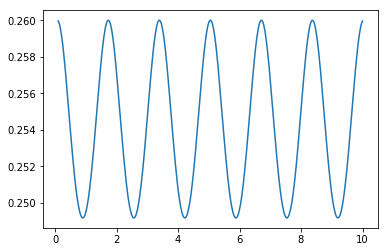

In [199]:

Hatom1 = Atom(position=[.26,0,0],initial_pos=[.25,0,0], element='H')
Hatom2 = Atom(position=[.75,0,0], element='H')

atoms  = [Hatom1,Hatom2]
#atoms = [Hatom1]
eng = MD_engine(cell=[[1,0,0],[0,1,0],[0,0,1]],input_atoms=atoms,verbosity=0,model='LJ',dx=.001)


eng.run(.5,.001)

#print([x for x in eng.trajs[0]])
plt.plot(np.linspace(10,.1,1000/2),[x[0] for x in eng.trajs[0]])

plt.show()

In [208]:
Hatom3 = Atom(position=[5,0,8], element='H')
atoms2  = [Hatom3]
eng = MD_engine(cell=[[1,.5,0],[1,-.5,0],[0,0,1.5]],input_atoms=atoms2,verbosity=0,model='LJ',dx=.001)

eng.assert_boundary_conditions(eng.atoms)
print(eng.atoms)

{'position': array([5, 0, 8]), 'velocity': array([0., 0., 0.]), 'force': array([0., 0., 0.]), 'mass': 1.0, 'element': 'H', 'constraint': [False, False, False], 'initial_pos': array([0, 0, 0])}
[1.  0.5 0. ]
[ 1.  -0.5  0. ]
[0.  0.  1.5]
Atom positions: [5 0 8]
Resultant coords: [2.5        2.5        5.33333333]
new position: [1.  0.  0.5]
